# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tqdm
import warnings
import zipfile
import PIL
from PIL import Image
warnings.filterwarnings("ignore")

# Loading the Data

In [2]:
path = r'Images'
image_size = (64, 64)  # Desired image size
batch_size = 64

In [3]:
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(path,
          label_mode = None, batch_size = batch_size, image_size=image_size)

Found 5734 files.


In [4]:
def show_image(data):
    '''This displays the image as the output'''
    fig, axs = plt.subplots(figsize=(15,10), nrows=3, ncols = 6)
    for i, images in zip(range(1,19),data.take(18)):
        axs = plt.subplot(3,6,i)
        axs.imshow(images[i].numpy().astype('uint8'))
        axs.axis('off')
    fig.tight_layout()

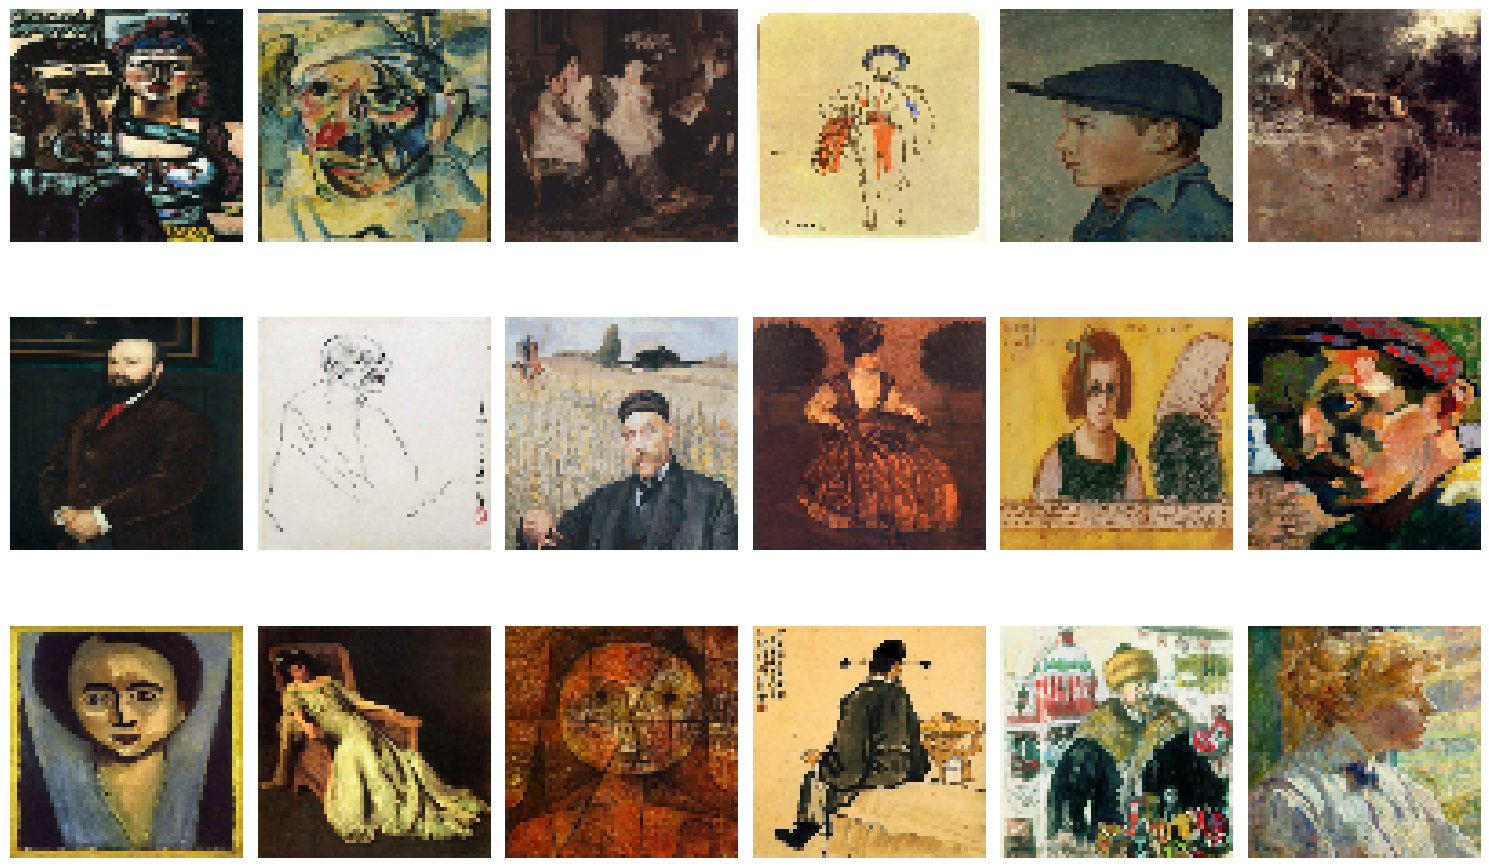

In [5]:
show_image(data)

# Building the VAE Model

In [6]:
# Define Model Parameters
original_dim = 28 * 28
image_shape = (28, 28, 1)
intermediate_dim = 512
latent_dim = 2

# Build the Encoder 

encoder_inputs = layers.Input(shape=image_shape)

Loading images from: Images
Found 5734 files.
✅ Data loading and preprocessing complete.


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 64, 64, 32)        │             896 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 32, 32, 64)        │          18,496 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 16, 16, 128)       │          73,856 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 8, 8, 256)         │         295,168 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 16384)             │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │       2,097,280 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 256)               │          33,024 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 256)               │          33,024 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z (Lambda)                    │ (None, 256)               │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,551,744 (9.73 MB)

 Trainable params: 2,551,744 (9.73 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32768)               │       8,421,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,991,363 (38.11 MB)

 Trainable params: 9,990,403 (38.11 MB)

 Non-trainable params: 960 (3.75 KB)


🔥 Starting VAE training...
Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - kl_loss: 27.0291 - loss: 10525.0020 - reconstruction_loss: 10497.9727
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - kl_loss: 66.7618 - loss: 9605.3584 - reconstruction_loss: 9538.5967
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - kl_loss: 81.7444 - loss: 9481.4805 - reconstruction_loss: 9399.7334
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - kl_loss: 87.5506 - loss: 9440.6572 - reconstruction_loss: 9353.1064
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - kl_loss: 94.8128 - loss: 9314.3984 - reconstruction_loss: 9219.5859
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - kl_loss: 96.2180 - loss: 9278.5312 - reconstruction_loss: 9182.3125
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - kl_loss: 96.6783 - loss: 9247.8271 - reconstruction_loss: 9151.1484
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - kl_loss: 97.7823 - loss: 9243.6084 - reconstruction_lo

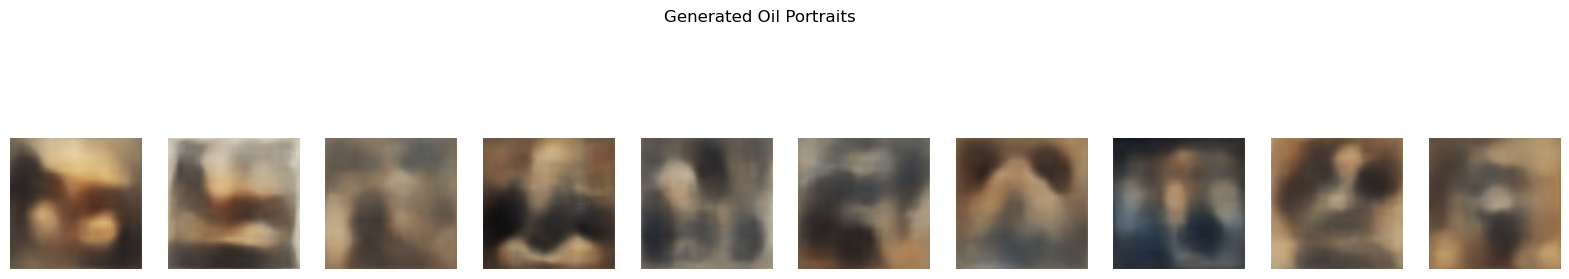

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt

# 1. Define Core Parameters ---
IMAGE_RESOLUTION = 128  # Resize your images to 128x128. Change if needed.
BATCH_SIZE = 32
LATENT_DIM = 256        # Latent space dimension. Larger for more complex images.
DATA_DIR = "Images"     # The name of your local folder with portrait images.
EPOCHS = 20            # Number of training epochs.

# 2. Load and Preprocess Data
print(f"Loading images from: {DATA_DIR}")
# This utility handles loading, resizing, and batching automatically.
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels=None,  # No labels needed for a VAE
    image_size=(IMAGE_RESOLUTION, IMAGE_RESOLUTION),
    batch_size=BATCH_SIZE,
    interpolation='bilinear' # A high-quality resizing method
)

# Normalize pixel values from the [0, 255] range to the [0, 1] range.
def preprocess(image):
    return tf.cast(image, tf.float32) / 255.0

train_dataset = train_dataset.map(preprocess)
print("✅ Data loading and preprocessing complete.")

# 3. Build a Deeper Encoder
# This encoder is more powerful to handle the complexity of 128x128 color images.
image_shape = (IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3)

encoder_inputs = layers.Input(shape=image_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

# --- 4. Reparameterization Trick ---
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(LATENT_DIM,), name='z')([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# --- 5. Build the Decoder ---
# This decoder architecture dynamically scales up to the target image resolution.
latent_inputs = layers.Input(shape=(LATENT_DIM,))
filters = 512
x = layers.Dense(8 * 8 * filters)(latent_inputs) # Start from an 8x8 feature map
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((8, 8, filters))(x)

# Dynamically add upsampling blocks to reach the target resolution
num_upsampling_blocks = int(np.log2(IMAGE_RESOLUTION) - np.log2(8))
for i in range(num_upsampling_blocks):
    filters //= 2
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

# Final output layer to produce a 3-channel (RGB) image
decoder_outputs = layers.Conv2D(3, kernel_size=3, activation="sigmoid", padding="same")(x)
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# --- 6. VAE Model with Custom Training Step ---
# This class combines the encoder and decoder and defines the custom loss logic.
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# --- 7. Instantiate, Compile, and Train the VAE ---
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

print("\n🔥 Starting VAE training...")
vae.fit(train_dataset, epochs=EPOCHS)
print("✅ Training complete.")

# --- 8. Generate and Plot New Portraits ---
def generate_and_plot_images(vae, num_images_to_generate=10):
    print("\n🎨 Generating new portraits from the latent space...")
    # Sample random points from the high-dimensional latent space
    random_latent_vectors = tf.random.normal(shape=(num_images_to_generate, LATENT_DIM))
    
    # Decode the random latent vectors into images
    generated_images = vae.decoder.predict(random_latent_vectors, verbose=0)

    # Plot the results
    plt.figure(figsize=(20, 4))
    for i in range(num_images_to_generate):
        ax = plt.subplot(1, num_images_to_generate, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.suptitle("Generated Oil Portraits")
    plt.show()

generate_and_plot_images(vae)


🧪 Testing the generator by creating new images...


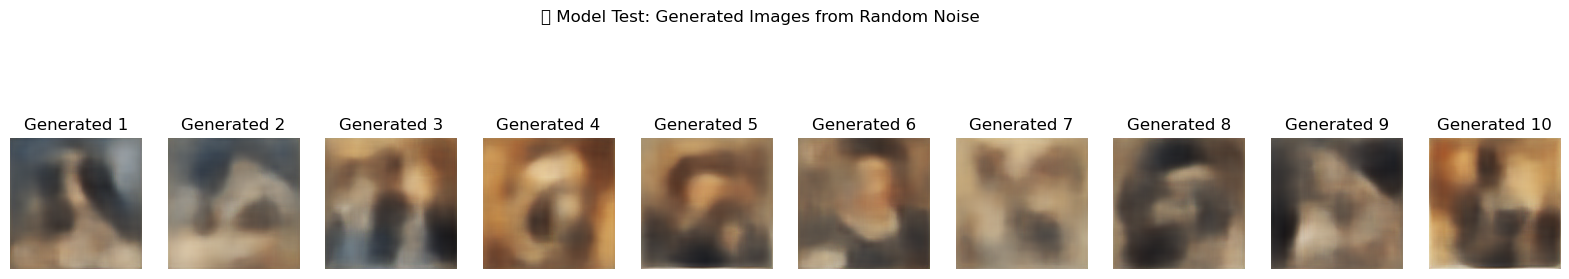

In [8]:
def test_and_visualize_generator(vae_model, num_images=10):
    """
    Tests the VAE's decoder by generating new images from random latent vectors.

    Args:
        vae_model (tf.keras.Model): The trained VAE model.
        num_images (int): The number of new images to generate and display.
    """
    print("\n🧪 Testing the generator by creating new images...")
    
    # 1. Create random vectors from the latent space distribution
    # The shape is (number_of_images, latent_dimension)
    latent_dim = vae_model.decoder.input_shape[-1]
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))

    # 2. Decode the random vectors into images
    # We use the .predict() method on the decoder part of the VAE
    generated_images = vae_model.decoder.predict(random_latent_vectors, verbose=0)

    # 3. Plot the generated images
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.title(f"Generated {i+1}")
        plt.axis("off")
    
    plt.suptitle("🎨 Model Test: Generated Images from Random Noise")
    plt.show()

# --- How to use it ---
# After your vae.fit() call completes, just call the function:
test_and_visualize_generator(vae)

In [9]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ?                           │       2,551,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ ?                           │       9,991,363 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,627,403 (143.54 MB)

 Trainable params: 12,542,147 (47.84 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 25,084,296 (95.69 MB)

In [10]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32768)               │       8,421,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,991,363 (38.11 MB)

 Trainable params: 9,990,403 (38.11 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 64, 64, 32)        │             896 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 32, 32, 64)        │          18,496 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 16, 16, 128)       │          73,856 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 8, 8, 256)         │         295,168 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 16384)             │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │       2,097,280 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 256)               │          33,024 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 256)               │          33,024 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z (Lambda)                    │ (None, 256)               │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,551,744 (9.73 MB)

 Trainable params: 2,551,744 (9.73 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
print("--- Verifying Component Shapes ---")
print("Encoder output shapes:", encoder.output_shape)
print("Decoder input shape:", decoder.input_shape)
print("---------------------------------")

--- Verifying Component Shapes ---
Encoder output shapes: [(None, 256), (None, 256), (None, 256)]
Decoder input shape: (None, 256)
---------------------------------


# Training Loss

In [13]:
history = vae.fit(train_dataset, epochs=EPOCHS)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - kl_loss: 91.1843 - loss: 9093.7969 - reconstruction_loss: 9002.6133
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - kl_loss: 91.5040 - loss: 9090.5244 - reconstruction_loss: 8999.0215
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - kl_loss: 91.5452 - loss: 9073.9404 - reconstruction_loss: 8982.3955
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - kl_loss: 91.9504 - loss: 9069.9141 - reconstruction_loss: 8977.9619
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - kl_loss: 91.2113 - loss: 9051.3672 - reconstruction_loss: 8960.1562
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - kl_loss: 91.1602 - loss: 9068.8828 - reconstruction_loss: 8977.7227
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - kl_loss: 92.2049 - loss: 9050.7998 - reconstruction_loss: 8958.5947
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - kl_loss: 91.1495 - loss: 9056.4170 - reconstruction_loss: 8965.2676
Epoch 9/20
180/1

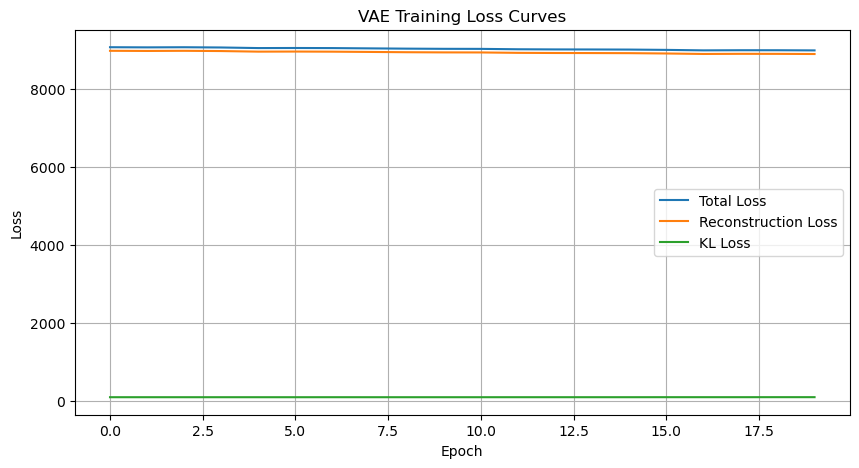

In [14]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """Plots the total, reconstruction, and KL loss from training."""
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Total Loss')
    plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.plot(history.history['kl_loss'], label='KL Loss')
    plt.title('VAE Training Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate the plot
plot_loss_curves(history)

# Latent Space Manifold

Generating latent space manifold...


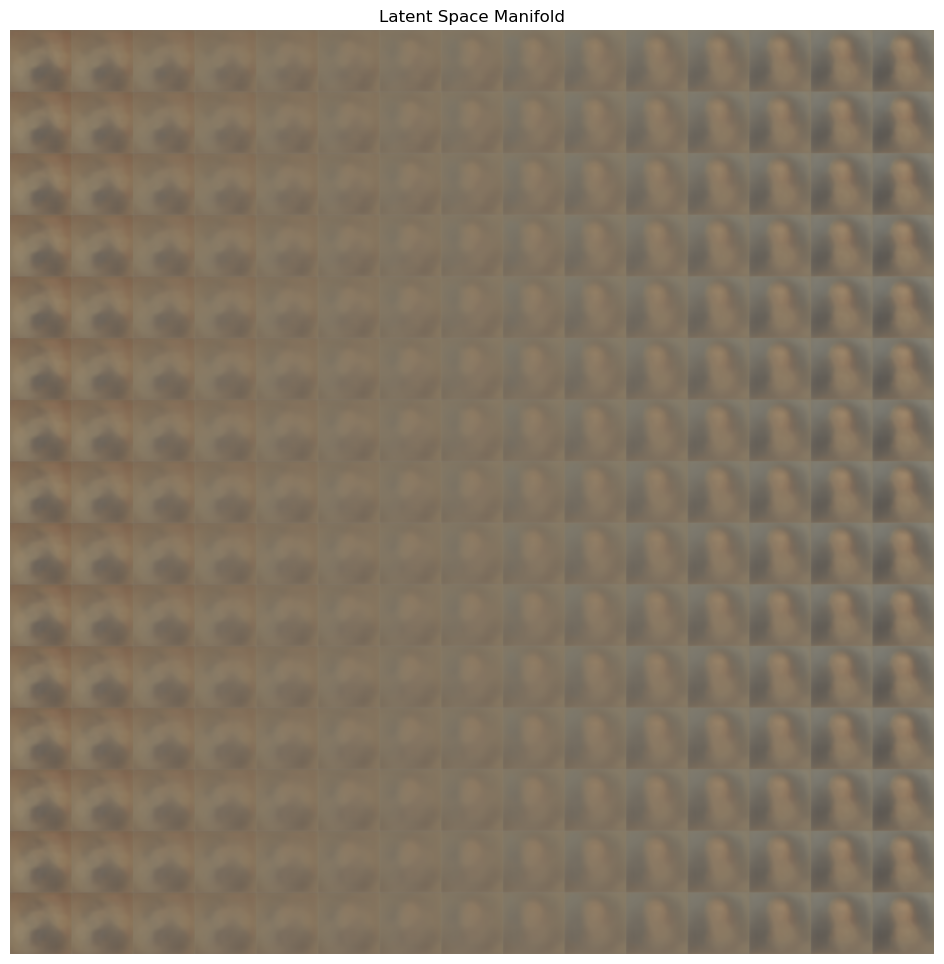

In [16]:
import numpy as np

def plot_latent_space_manifold(decoder, grid_size=15, scale=1.5):
    """
    Displays a 2D manifold of generated images.
    NOTE: Works best with a model trained with LATENT_DIM = 2.
    """
    # Create a grid of (x, y) coordinates that will be our latent vectors
    x_coords = np.linspace(-scale, scale, grid_size)
    y_coords = np.linspace(-scale, scale, grid_size)
    
    # Get the latent dimension from the decoder's input shape
    latent_dim = decoder.input_shape[-1]
    
    # Create the figure to display the manifold
    manifold_image = np.zeros((grid_size * IMAGE_RESOLUTION, grid_size * IMAGE_RESOLUTION, 3))

    print("Generating latent space manifold...")
    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            # For a 2D latent space, the vector is just (x, y)
            latent_vector = np.array([[x, y]])
            
            # If latent_dim > 2, we sample x,y and keep the rest of the dims zero
            if latent_dim > 2:
                base_vector = np.zeros((1, latent_dim))
                base_vector[0, 0] = x
                base_vector[0, 1] = y
                latent_vector = base_vector

            # Decode the latent vector to an image
            generated_image = decoder.predict(latent_vector, verbose=0)[0]
            
            # Place the generated image onto the correct spot in the manifold
            start_row, end_row = i * IMAGE_RESOLUTION, (i + 1) * IMAGE_RESOLUTION
            start_col, end_col = j * IMAGE_RESOLUTION, (j + 1) * IMAGE_RESOLUTION
            manifold_image[start_row:end_row, start_col:end_col] = generated_image

    plt.figure(figsize=(12, 12))
    plt.imshow(manifold_image)
    plt.title("Latent Space Manifold")
    plt.axis("off")
    plt.show()

# Generate the plot (use 'decoder' which is part of your 'vae' model)
plot_latent_space_manifold(vae.decoder)